📂 데이터 로드 및 통합

[1] 일별 RP 금리 DB 로드...
  ✓ 2015-2019: 1231일, 컬럼: ['전체', 'CP', '국채', '금융채', '은행채']...
  ✓ 2020-2024: 1210일, 컬럼: ['전체', 'CP', '국채', '금융채', '은행채']...
  ✓ 2025: 238일, 컬럼: ['전체', '국채', '금융채', '은행채', '주식.ETF']...

  → 통합 완료: 2679일
  → 기간: 2015-01-02 ~ 2025-12-31
  → 담보유형: ['전체', 'CP', '국채', '금융채', '은행채', '주식.ETF', '지방채', '통안채', '특수채', '회사채']

[2] 시장금리 데이터 로드...
  ✓ 기준금리 로드 완료: 6199일

[3] 스프레드 계산...
  ✓ 스프레드 계산 완료: 2679일
  → 담보유형: ['전체', 'CP', '국채', '금융채', '은행채', '주식.ETF', '지방채', '통안채', '특수채', '회사채']

📊 기초통계량

[전체 기간 기초통계 - 스프레드(bp)]
------------------------------------------------------------------------------------------
           N     평균   표준편차    최소    25%   중앙값    75%     최대
전체      2679   3.30   8.59 -30.6  -0.50   3.1   7.60  105.2
CP       466  12.57  18.85 -27.0   5.00  10.0  15.23  105.0
국채      2679   2.51   8.46 -30.8  -0.90   2.4   6.80   99.5
금융채     2679   8.75  11.83 -29.8   4.55   8.2  12.90  234.9
은행채     2679   3.86   8.25 -28.5   0.00   3.5   8.05   96.8
주식

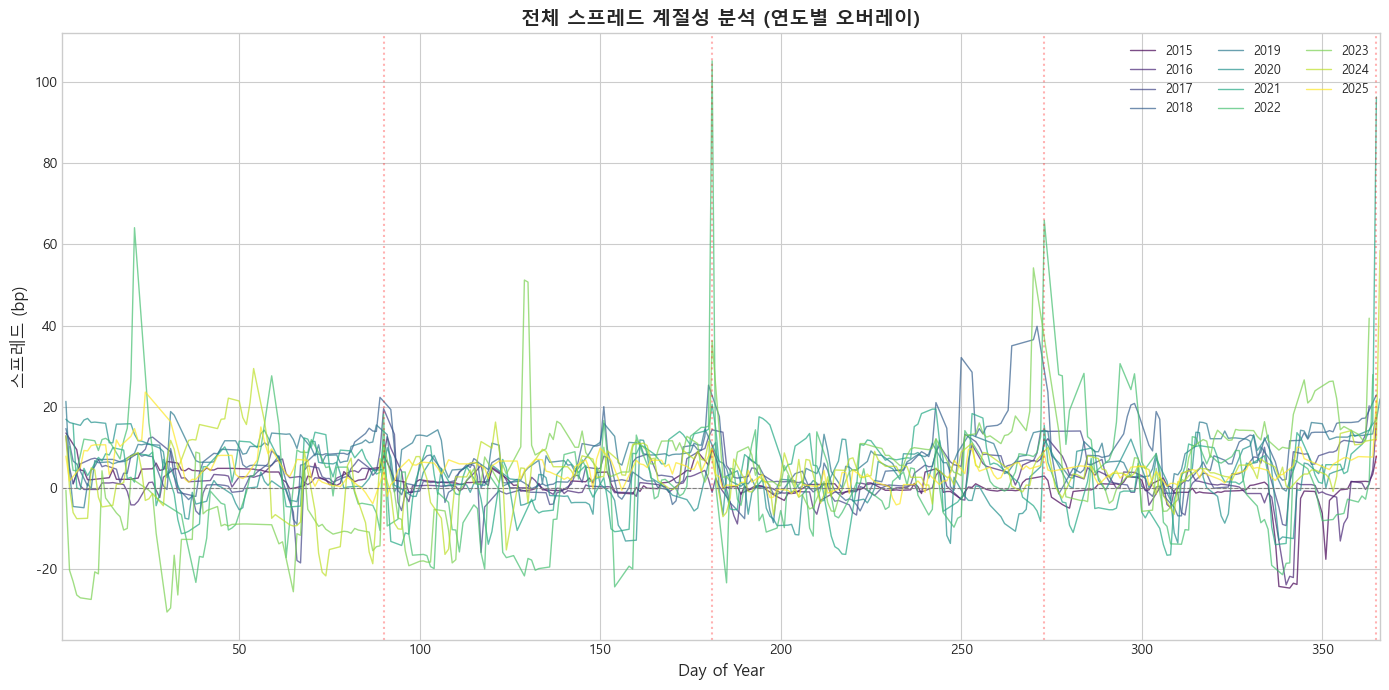

  ✓ 전체 계절성 그래프 저장: ./output/fig_seasonality_전체.png


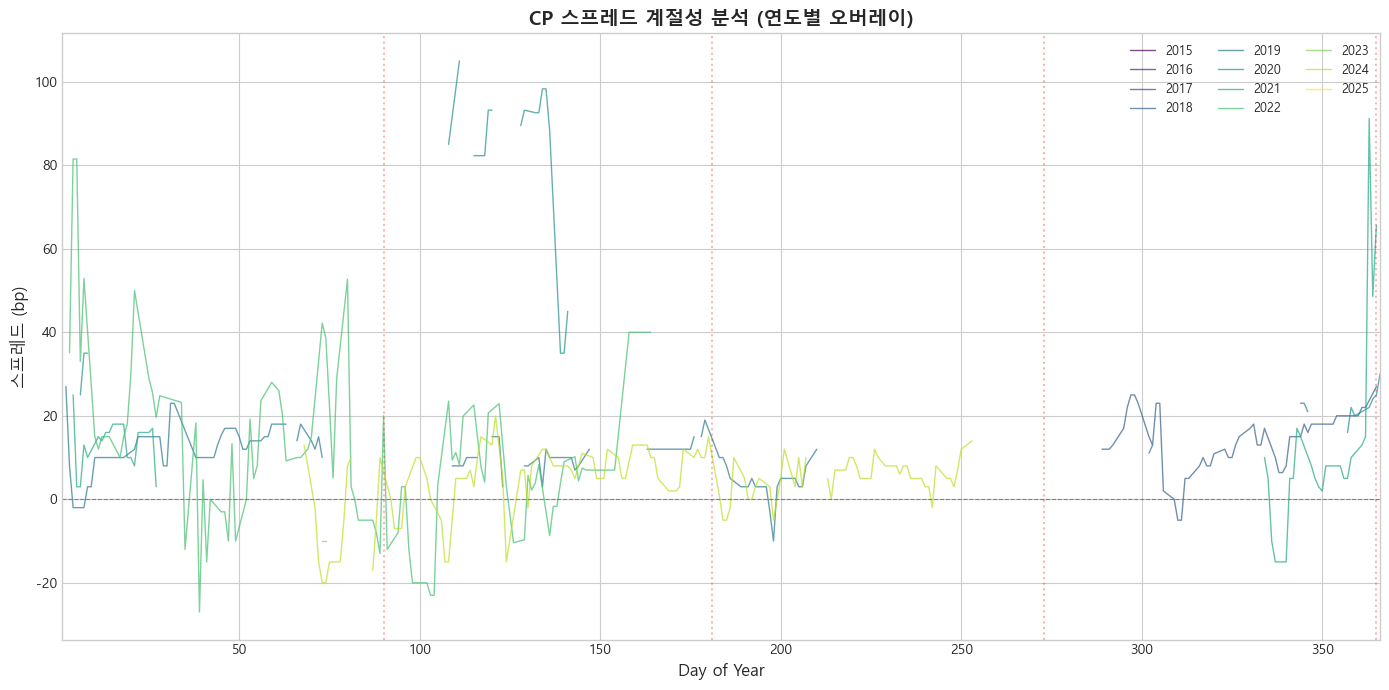

  ✓ CP 계절성 그래프 저장: ./output/fig_seasonality_CP.png


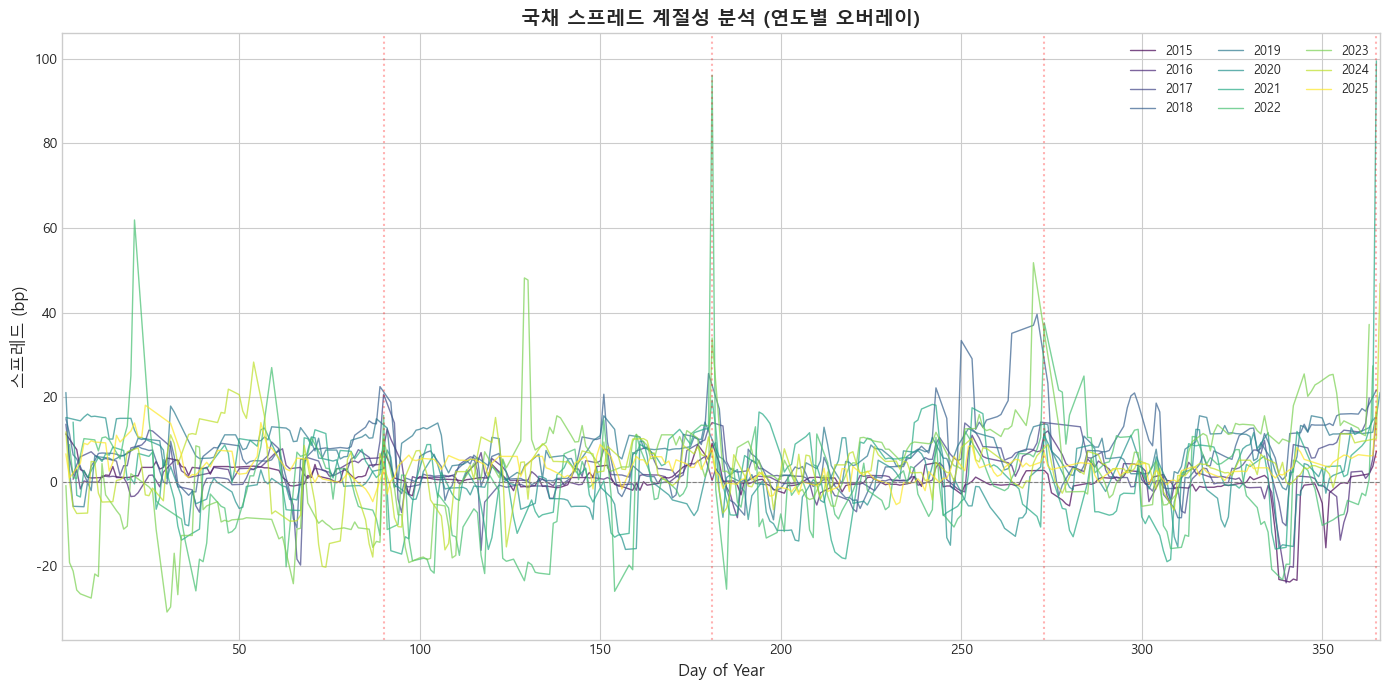

  ✓ 국채 계절성 그래프 저장: ./output/fig_seasonality_국채.png


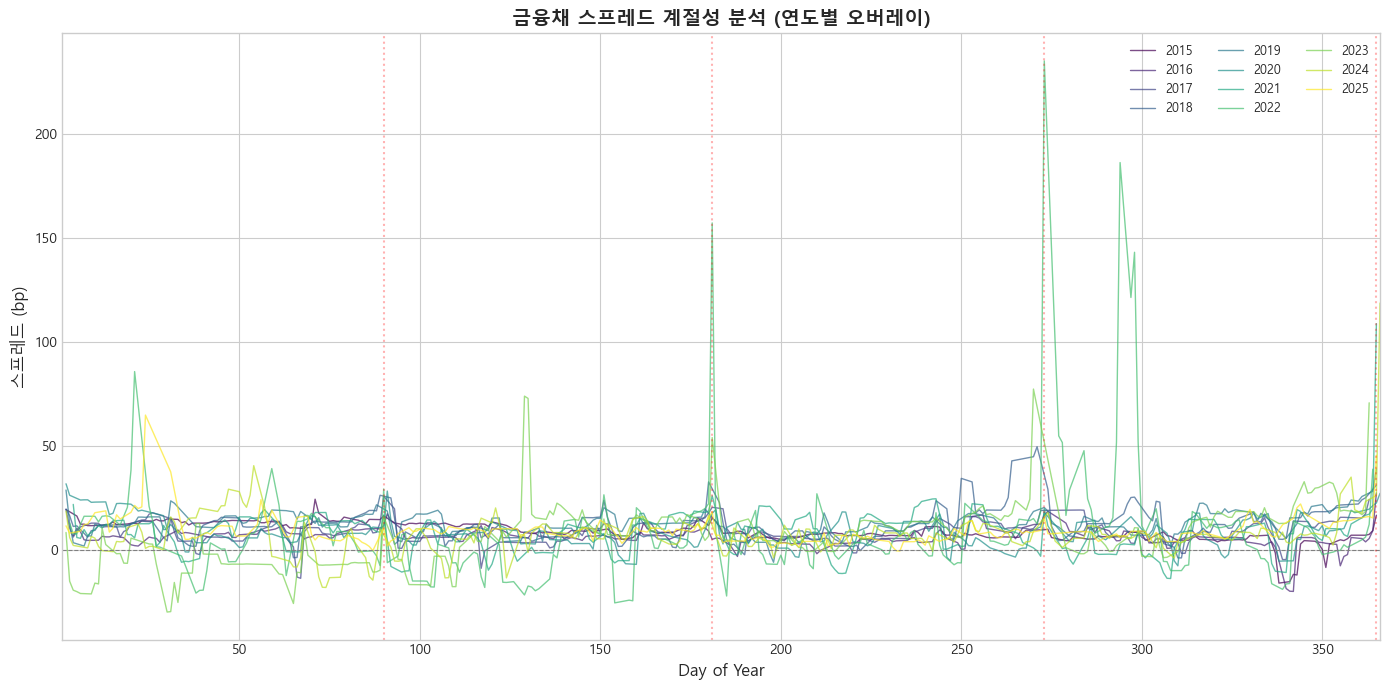

  ✓ 금융채 계절성 그래프 저장: ./output/fig_seasonality_금융채.png


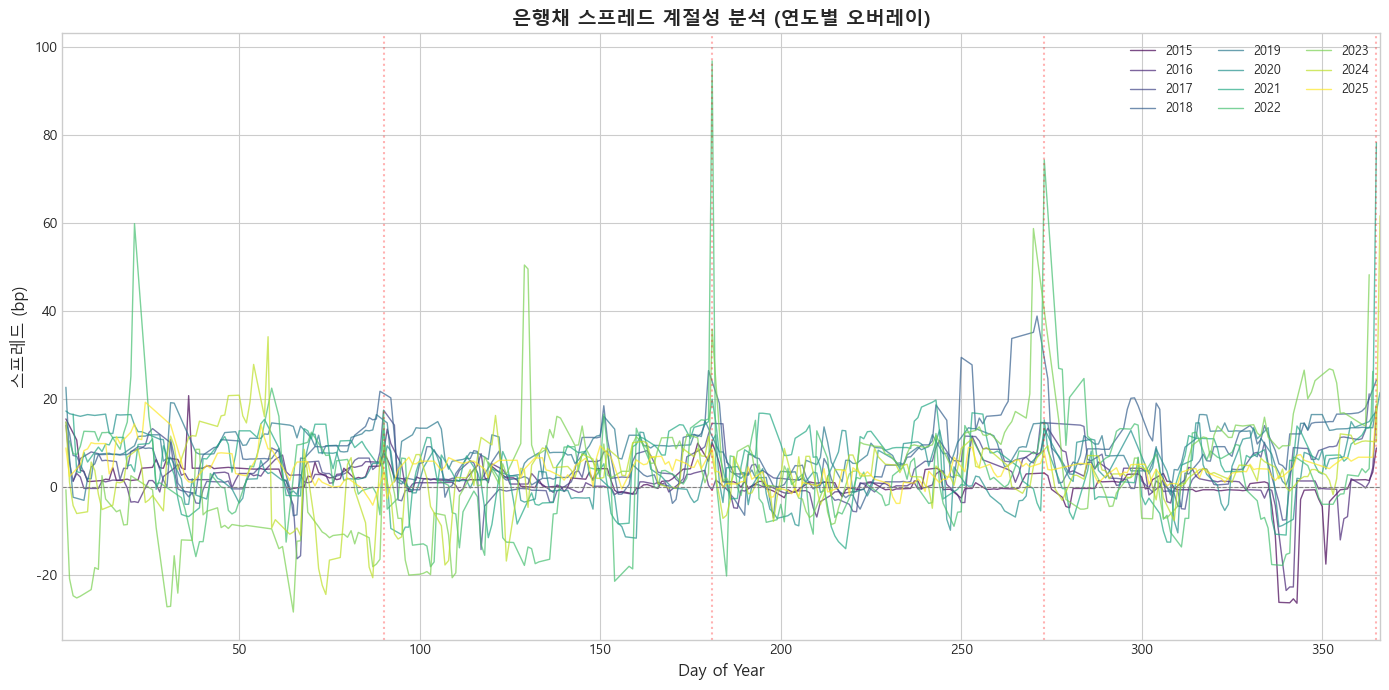

  ✓ 은행채 계절성 그래프 저장: ./output/fig_seasonality_은행채.png


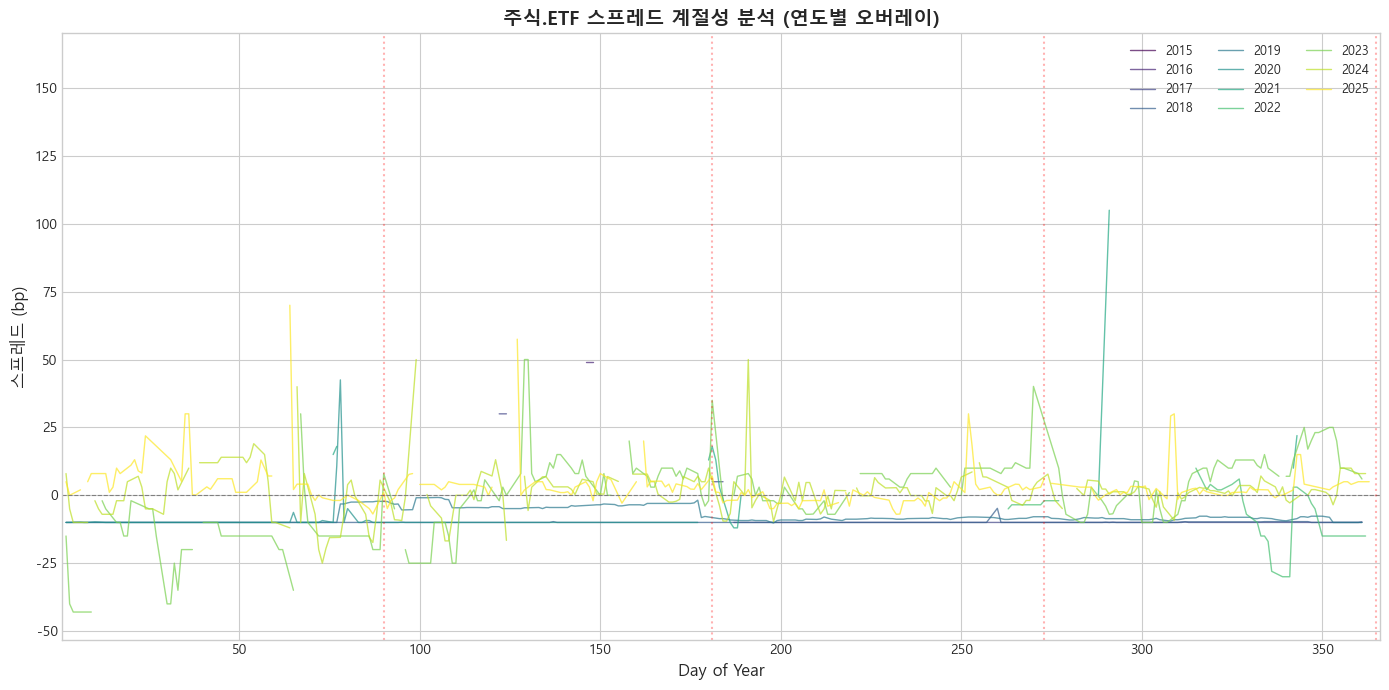

  ✓ 주식.ETF 계절성 그래프 저장: ./output/fig_seasonality_주식.ETF.png


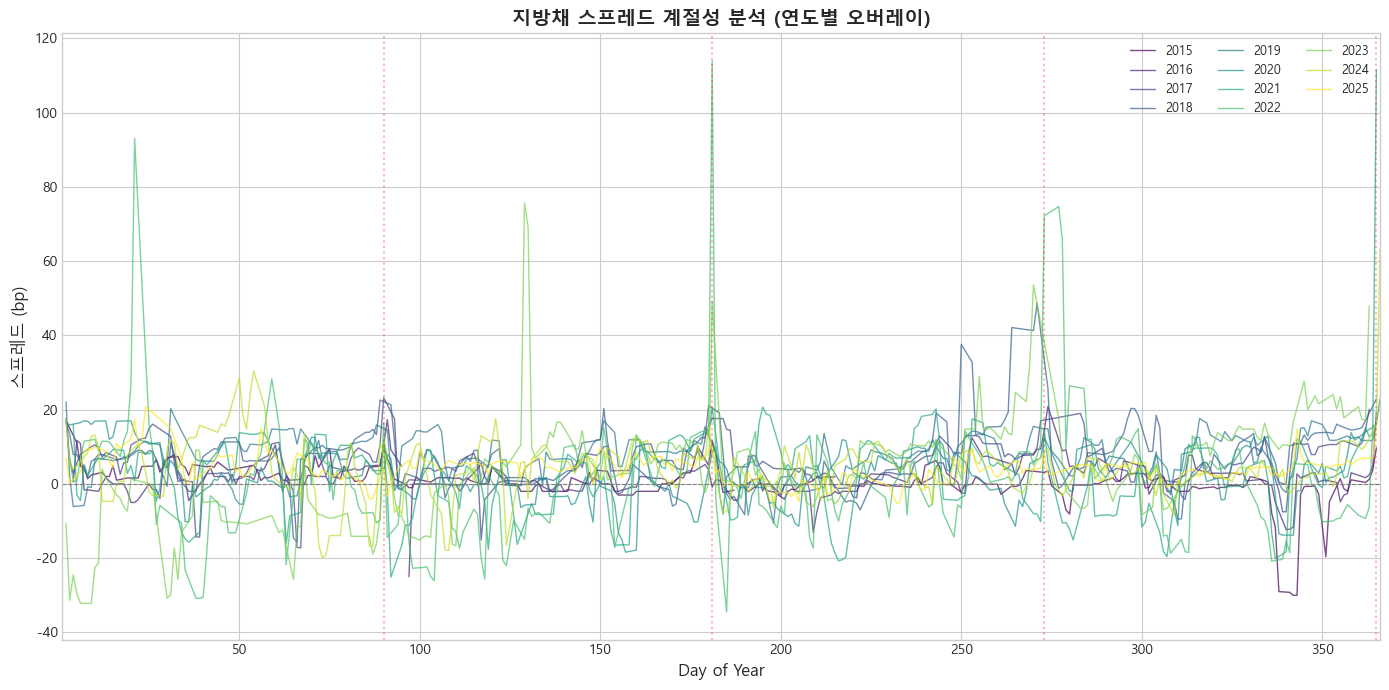

  ✓ 지방채 계절성 그래프 저장: ./output/fig_seasonality_지방채.png


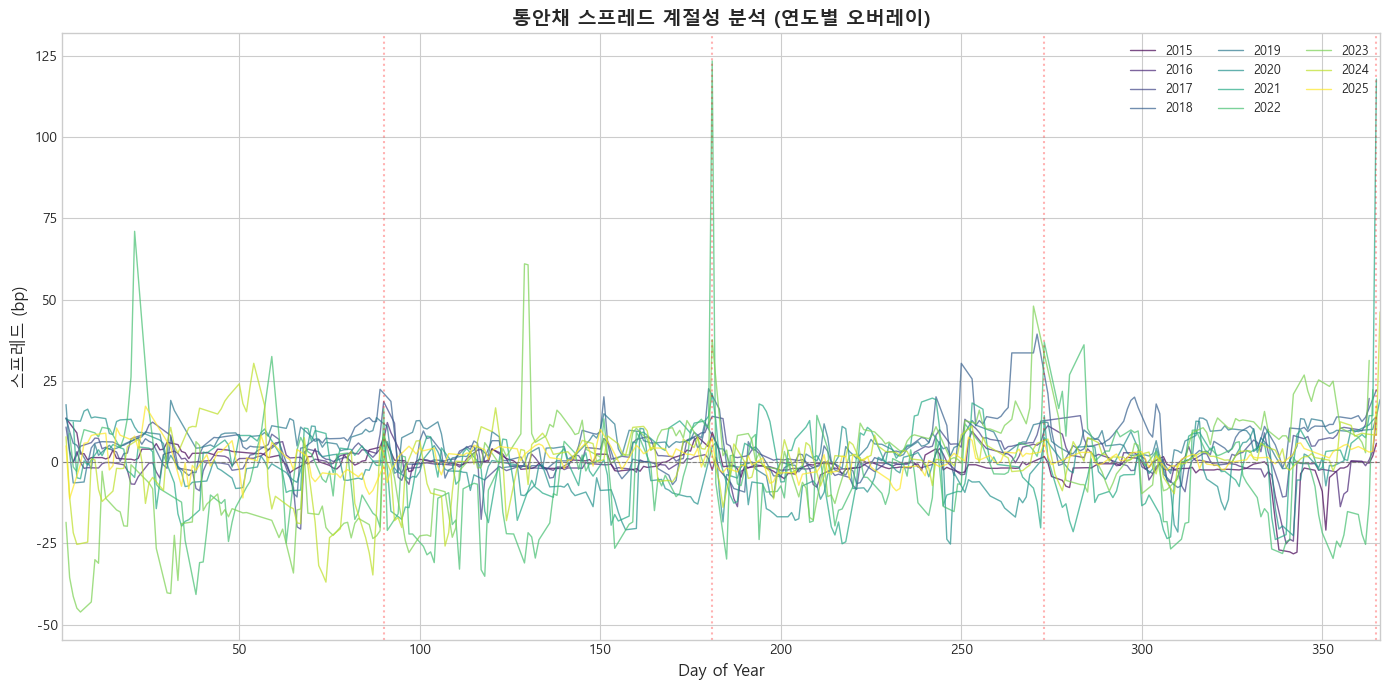

  ✓ 통안채 계절성 그래프 저장: ./output/fig_seasonality_통안채.png


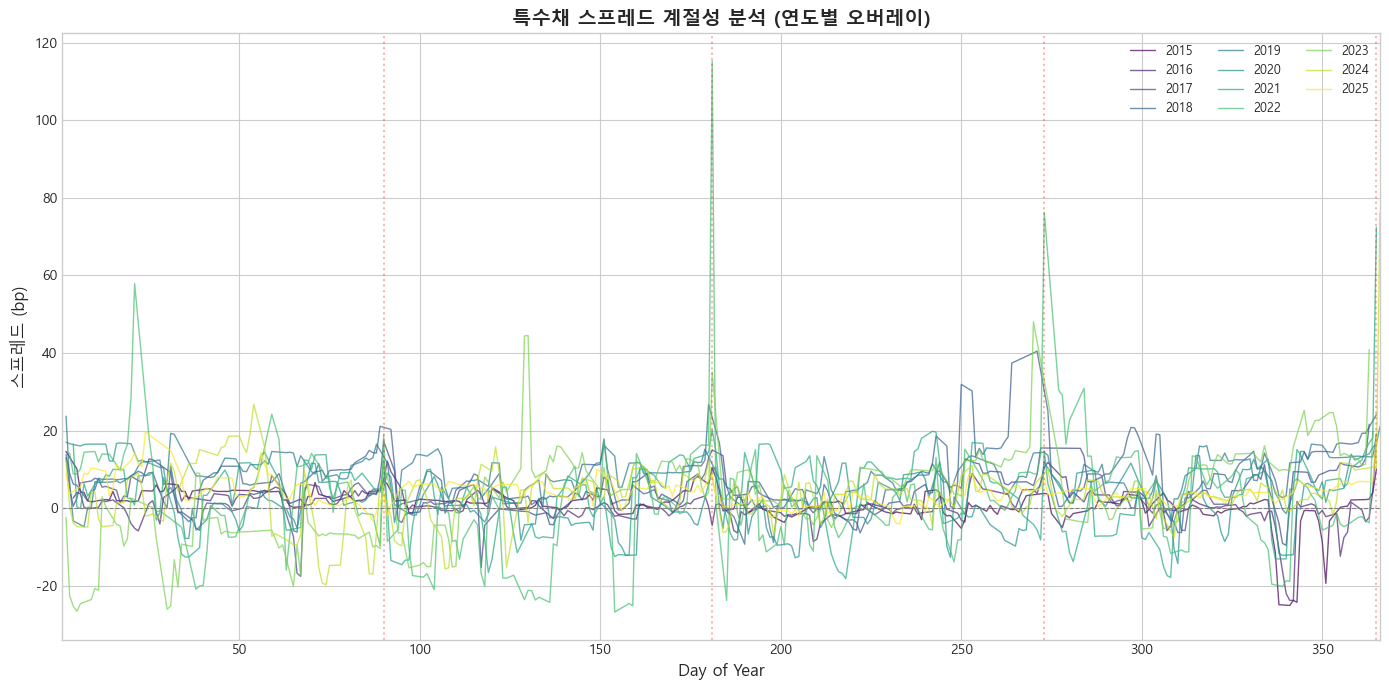

  ✓ 특수채 계절성 그래프 저장: ./output/fig_seasonality_특수채.png


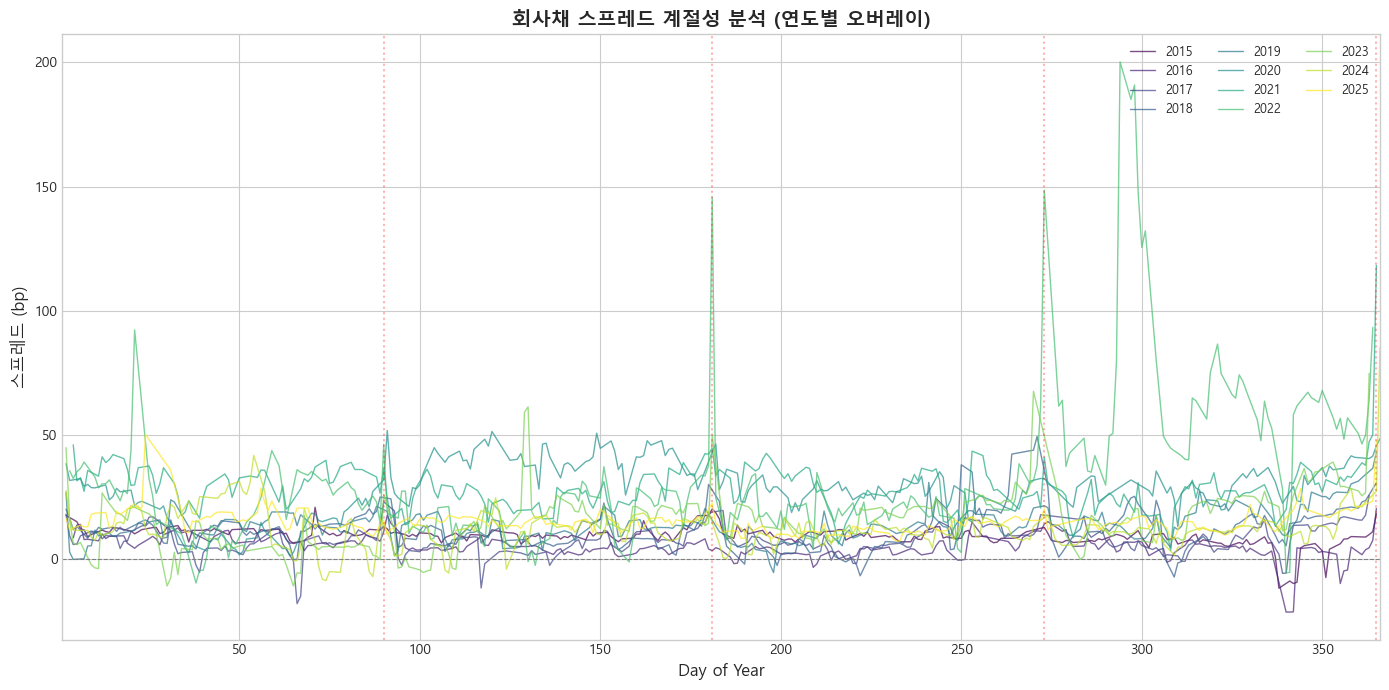

  ✓ 회사채 계절성 그래프 저장: ./output/fig_seasonality_회사채.png

📊 거래대금 집계 (원본 DB)
  ✓ 2015-2019: 거래대금 집계 완료
  ✓ 2020-2024: 거래대금 집계 완료
  ✓ 2025: 거래대금 집계 완료

  → 연도별 전체 거래대금: 11년
  → 연도별 담보별 거래대금: 95건

📊 Figure 2: 연도별 전체 RP 거래대금


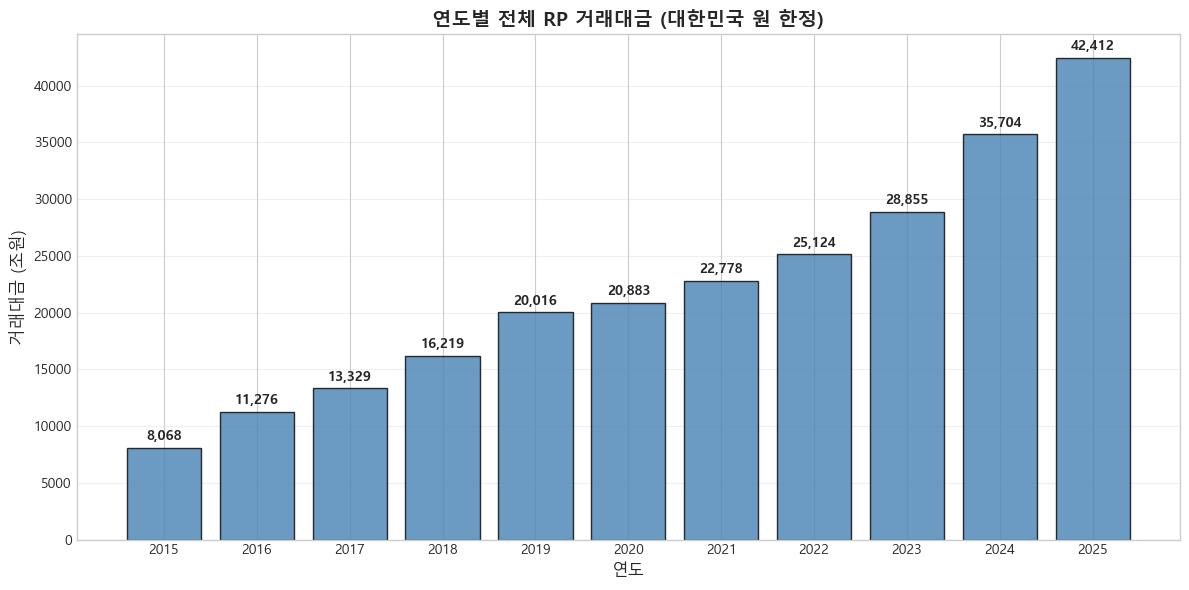

  ✓ 저장 완료: ./output/fig_annual_volume.png

📊 Figure 3: 익일물 담보별 거래대금 (Stacked)
  담보유형 순서 (거래대금 큰 순): ['국채', '은행채', '특수채', '금융채', '통안채']...


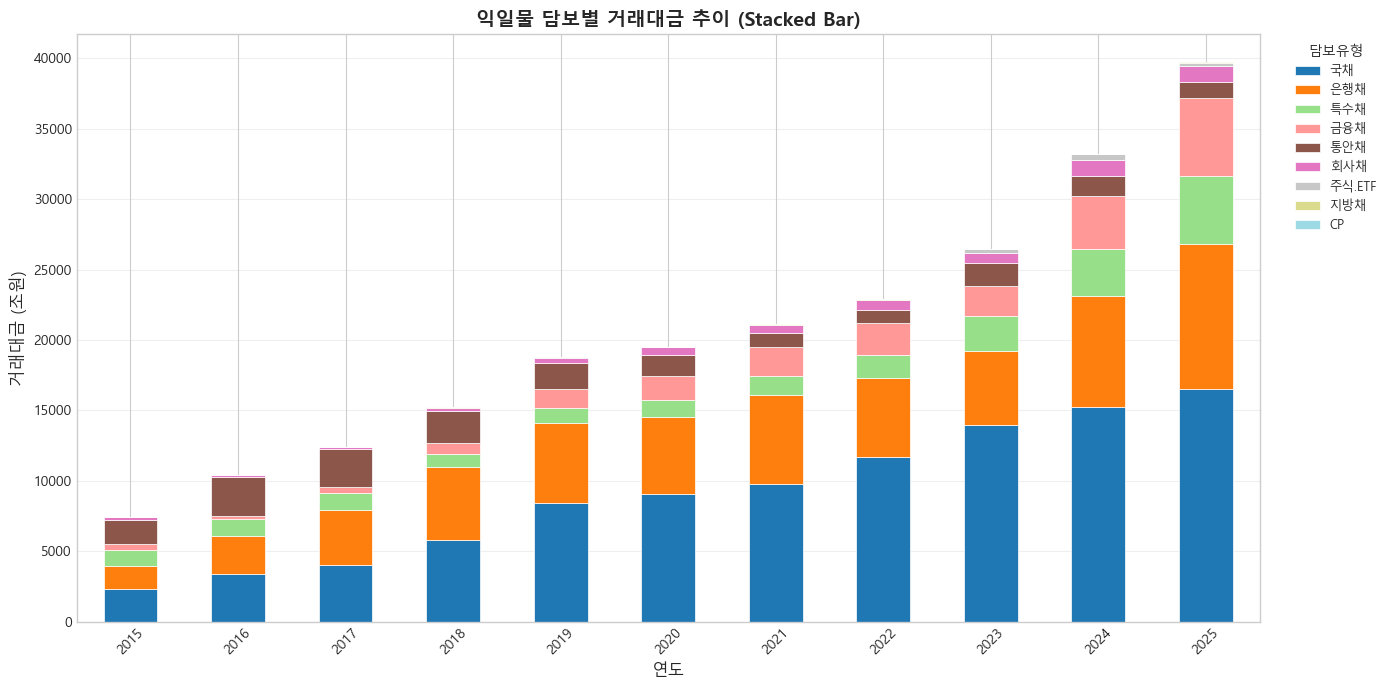

  ✓ 저장 완료: ./output/fig_collateral_volume_stacked.png

📊 Figure 4: 익일물 담보별 거래 비중 (Stacked 100%)


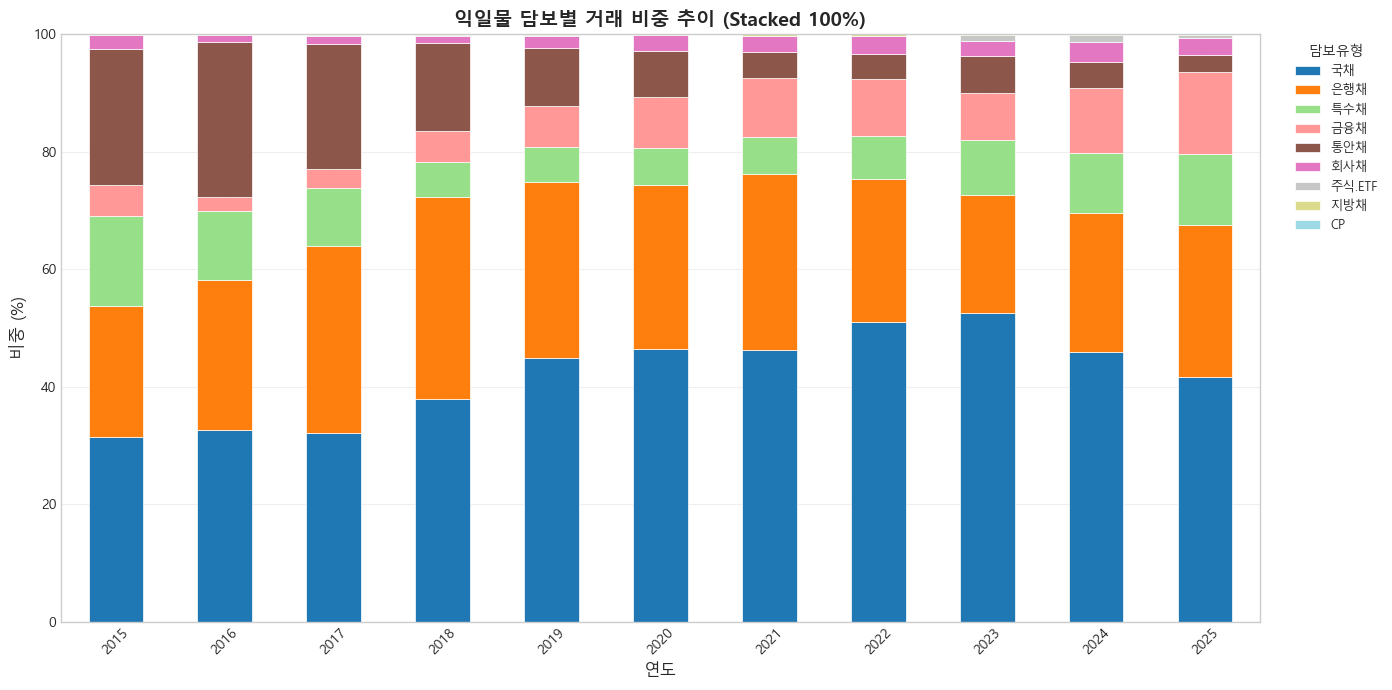

  ✓ 저장 완료: ./output/fig_collateral_share_stacked.png

✅ 분석 완료!

[저장된 파일 목록] (./output/)
--------------------------------------------------
  - spread_summary_stats.csv      : 기초통계량
  - fig_seasonality_*.png         : 계절성 그래프 (담보별)
  - fig_annual_volume.png         : 연도별 전체 거래대금
  - fig_collateral_volume_stacked.png : 담보별 거래대금 (Stacked)
  - fig_collateral_share_stacked.png  : 담보별 비중 (Stacked 100%)

[기초통계 요약]
--------------------------------------------------
  전체 스프레드 평균: 3.30 bp
  전체 스프레드 표준편차: 8.59 bp

[거래대금 요약]
--------------------------------------------------
  총 거래대금 (2015-2025): 244,665 조원
  연평균 거래대금: 22,242 조원


In [3]:
#%%============================================================================
# [Cell 5] RP 시장 기초통계 및 시각화
#==============================================================================
"""
[분석 내용]
1. DB 연결 및 데이터 통합 (2015-2025)
2. 기초통계량 산출 (전체 및 담보별 스프레드)
3. Figure 1: 계절성 분석 (연도별 오버레이 선그래프)
4. Figure 2: 연도별 전체 RP 거래대금 (Bar Chart) - 대한민국 원 한정
5. Figure 3: 익일물 담보별 거래대금 (Stacked Bar Chart)
"""

import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ========================== 사용자 설정 ==========================
# 경로 설정
BASE_PATH = r'C:\Users\jay15\Desktop\DB_DATA'

# 일별 RP 금리 DB (가중평균 금리)
repo_rate_dbs = {
    '2015-2019': f'{BASE_PATH}\\D_Repo_2015-2019.db',
    '2020-2024': f'{BASE_PATH}\\D_Repo_2020-2024.db',
    '2025': f'{BASE_PATH}\\D_Repo_2025.db'
}

# 원본 거래 DB (거래대금 집계용)
repo_trade_dbs = {
    '2015-2019': f'{BASE_PATH}\\r_2015-2019.db',
    '2020-2024': f'{BASE_PATH}\\r_2020-2024.db',
    '2025': f'{BASE_PATH}\\r_2025.db'
}

# 시장금리 파일
rate_path = f'{BASE_PATH}\\시장금리(일별)_250109.csv'

# 출력 폴더
OUTPUT_DIR = './output'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
# ================================================================

print("=" * 70)
print("📂 데이터 로드 및 통합")
print("=" * 70)

# =============================================================================
# 1. 일별 RP 금리 데이터 통합
# =============================================================================
print("\n[1] 일별 RP 금리 DB 로드...")

df_repo_list = []

for period, db_path in repo_rate_dbs.items():
    try:
        conn = sqlite3.connect(db_path)
        df_temp = pd.read_sql("SELECT * FROM daily_repo_rates", conn)
        conn.close()
        
        # 날짜 컬럼 처리
        if 'basDt' in df_temp.columns:
            df_temp['date'] = pd.to_datetime(df_temp['basDt'])
            df_temp = df_temp.drop(columns=['basDt'])
        elif 'index' in df_temp.columns:
            df_temp['date'] = pd.to_datetime(df_temp['index'])
            df_temp = df_temp.drop(columns=['index'])
        
        df_temp = df_temp.set_index('date')
        df_repo_list.append(df_temp)
        print(f"  ✓ {period}: {len(df_temp)}일, 컬럼: {df_temp.columns.tolist()[:5]}...")
        
    except Exception as e:
        print(f"  ✗ {period}: 로드 실패 ({e})")

# 통합
df_repo = pd.concat(df_repo_list, axis=0)
df_repo = df_repo.sort_index()
df_repo = df_repo[~df_repo.index.duplicated(keep='first')]  # 중복 제거

print(f"\n  → 통합 완료: {len(df_repo)}일")
print(f"  → 기간: {df_repo.index.min().strftime('%Y-%m-%d')} ~ {df_repo.index.max().strftime('%Y-%m-%d')}")
print(f"  → 담보유형: {df_repo.columns.tolist()}")

# =============================================================================
# 2. 기준금리 데이터 로드
# =============================================================================
print("\n[2] 시장금리 데이터 로드...")

df_rate = pd.read_csv(rate_path, encoding='utf-8')
df_rate['date'] = pd.to_datetime(df_rate['DATE'])
df_rate.columns = df_rate.columns.str.strip()

# 기준금리 컬럼 찾기
base_rate_col = None
for col in df_rate.columns:
    if '기준금리' in col:
        base_rate_col = col
        break

if base_rate_col:
    df_rate = df_rate[['date', base_rate_col]].rename(columns={base_rate_col: 'BASE_RATE'})
    df_rate = df_rate.set_index('date')
    print(f"  ✓ 기준금리 로드 완료: {len(df_rate)}일")
else:
    print("  ✗ 기준금리 컬럼을 찾을 수 없습니다.")

# =============================================================================
# 3. 스프레드 계산 (RP 금리 - 기준금리, bp 단위)
# =============================================================================
print("\n[3] 스프레드 계산...")

# 기준금리 병합
df_spread = df_repo.join(df_rate[['BASE_RATE']], how='inner')

# 스프레드 계산 (bp)
collateral_cols = [col for col in df_repo.columns if col != 'BASE_RATE']
for col in collateral_cols:
    df_spread[f'{col}_spread'] = (df_spread[col] - df_spread['BASE_RATE']) * 100

# 스프레드 컬럼만 추출
spread_cols = [col for col in df_spread.columns if '_spread' in col]
df_spread_only = df_spread[spread_cols].copy()
df_spread_only.columns = [col.replace('_spread', '') for col in spread_cols]

print(f"  ✓ 스프레드 계산 완료: {len(df_spread_only)}일")
print(f"  → 담보유형: {df_spread_only.columns.tolist()}")

# =============================================================================
# 4. 기초통계량 산출
# =============================================================================
print(f"\n{'='*70}")
print("📊 기초통계량")
print("=" * 70)

# 전체 기간 기초통계
stats = df_spread_only.describe().T
stats['count'] = stats['count'].astype(int)
stats = stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
stats.columns = ['N', '평균', '표준편차', '최소', '25%', '중앙값', '75%', '최대']

print("\n[전체 기간 기초통계 - 스프레드(bp)]")
print("-" * 90)
print(stats.round(2).to_string())

# 연도별 기초통계 (전체 담보)
if '전체' in df_spread_only.columns:
    print("\n\n[연도별 기초통계 - 전체 스프레드(bp)]")
    print("-" * 70)
    
    df_spread_only['year'] = df_spread_only.index.year
    yearly_stats = df_spread_only.groupby('year')['전체'].agg(['count', 'mean', 'std', 'min', 'max'])
    yearly_stats.columns = ['N', '평균', '표준편차', '최소', '최대']
    print(yearly_stats.round(2).to_string())
    df_spread_only = df_spread_only.drop(columns=['year'])

# CSV 저장
stats.to_csv(f'{OUTPUT_DIR}/spread_summary_stats.csv', encoding='utf-8-sig')
print(f"\n  ✓ 기초통계 저장: {OUTPUT_DIR}/spread_summary_stats.csv")


# =============================================================================
# 5. Figure 1: 계절성 분석 (연도별 오버레이 선그래프)
# =============================================================================
print(f"\n{'='*70}")
print("📊 Figure 1: 계절성 분석 (연도별 오버레이)")
print("=" * 70)

def plot_seasonality(df, col_name, output_path):
    """연도별 오버레이 선그래프"""
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 연도별로 분리
    df_temp = df[[col_name]].copy()
    df_temp['year'] = df_temp.index.year
    df_temp['dayofyear'] = df_temp.index.dayofyear
    
    years = sorted(df_temp['year'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(years)))
    
    for year, color in zip(years, colors):
        yearly_data = df_temp[df_temp['year'] == year].copy()
        yearly_data = yearly_data.sort_values('dayofyear')
        
        ax.plot(yearly_data['dayofyear'], yearly_data[col_name], 
                label=str(year), color=color, alpha=0.7, linewidth=1)
    
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Day of Year', fontsize=12)
    ax.set_ylabel('스프레드 (bp)', fontsize=12)
    ax.set_title(f'{col_name} 스프레드 계절성 분석 (연도별 오버레이)', fontsize=14, fontweight='bold')
    
    # 분기 표시
    for q_day, q_name in [(90, 'Q1'), (181, 'Q2'), (273, 'Q3'), (365, 'Q4')]:
        ax.axvline(x=q_day, color='red', linestyle=':', alpha=0.3)
    
    ax.legend(loc='upper right', ncol=3, fontsize=9)
    ax.set_xlim(1, 366)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# 각 담보유형별 계절성 그래프
for col in df_spread_only.columns:
    if df_spread_only[col].notna().sum() > 100:  # 충분한 데이터가 있는 경우만
        output_path = f'{OUTPUT_DIR}/fig_seasonality_{col}.png'
        plot_seasonality(df_spread_only, col, output_path)
        print(f"  ✓ {col} 계절성 그래프 저장: {output_path}")


# =============================================================================
# 6. 원본 DB에서 거래대금 집계
# =============================================================================
print(f"\n{'='*70}")
print("📊 거래대금 집계 (원본 DB)")
print("=" * 70)

# 연도별 전체 거래대금
annual_volume = []
# 연도별 담보별 거래대금 (익일물)
annual_collateral_volume = []

for period, db_path in repo_trade_dbs.items():
    try:
        conn = sqlite3.connect(db_path)
        
        # ---------------------------------------------------------------------
        # 6-1) 연도별 전체 거래대금 (대한민국 원 한정)
        # ---------------------------------------------------------------------
        query_total = """
            SELECT 
                SUBSTR(basDt, 1, 4) as year,
                SUM(CAST(rpBuyAmt AS REAL)) as total_amount
            FROM repo_trades
            WHERE rpBuyAplCurCdNm = '대한민국 원'
            GROUP BY SUBSTR(basDt, 1, 4)
        """
        df_total = pd.read_sql(query_total, conn)
        annual_volume.append(df_total)
        
        # ---------------------------------------------------------------------
        # 6-2) 연도별 담보별 거래대금 (익일물, 대한민국 원 한정)
        # ---------------------------------------------------------------------
        query_collateral = """
            SELECT 
                SUBSTR(basDt, 1, 4) as year,
                scrsItmsKcdNm as collateral,
                SUM(CAST(rpBuyAmt AS REAL)) as amount
            FROM repo_trades
            WHERE rpBuyAplCurCdNm = '대한민국 원'
              AND rdptTermCcdNm = '1영업일'
            GROUP BY SUBSTR(basDt, 1, 4), scrsItmsKcdNm
        """
        df_coll = pd.read_sql(query_collateral, conn)
        annual_collateral_volume.append(df_coll)
        
        conn.close()
        print(f"  ✓ {period}: 거래대금 집계 완료")
        
    except Exception as e:
        print(f"  ✗ {period}: 집계 실패 ({e})")

# 통합
df_annual_volume = pd.concat(annual_volume, ignore_index=True)
df_annual_volume = df_annual_volume.groupby('year')['total_amount'].sum().reset_index()
df_annual_volume['total_amount_조'] = df_annual_volume['total_amount'] / 1e12  # 조원 단위

df_collateral_volume = pd.concat(annual_collateral_volume, ignore_index=True)
df_collateral_volume = df_collateral_volume.groupby(['year', 'collateral'])['amount'].sum().reset_index()
df_collateral_volume['amount_조'] = df_collateral_volume['amount'] / 1e12  # 조원 단위

print(f"\n  → 연도별 전체 거래대금: {len(df_annual_volume)}년")
print(f"  → 연도별 담보별 거래대금: {len(df_collateral_volume)}건")


# =============================================================================
# 7. Figure 2: 연도별 전체 RP 거래대금 (Bar Chart)
# =============================================================================
print(f"\n{'='*70}")
print("📊 Figure 2: 연도별 전체 RP 거래대금")
print("=" * 70)

fig2, ax2 = plt.subplots(figsize=(12, 6))

years = df_annual_volume['year'].astype(str)
amounts = df_annual_volume['total_amount_조']

bars = ax2.bar(years, amounts, color='steelblue', alpha=0.8, edgecolor='black')

# 값 표시
for bar, val in zip(bars, amounts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(amounts)*0.01, 
             f'{val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xlabel('연도', fontsize=12)
ax2.set_ylabel('거래대금 (조원)', fontsize=12)
ax2.set_title('연도별 전체 RP 거래대금 (대한민국 원 한정)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fig_annual_volume.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"  ✓ 저장 완료: {OUTPUT_DIR}/fig_annual_volume.png")


# =============================================================================
# 8. Figure 3: 익일물 담보별 거래대금 (Stacked Bar Chart)
# =============================================================================
print(f"\n{'='*70}")
print("📊 Figure 3: 익일물 담보별 거래대금 (Stacked)")
print("=" * 70)

# 피벗 (행: 연도, 열: 담보유형)
df_pivot = df_collateral_volume.pivot(index='year', columns='collateral', values='amount_조')
df_pivot = df_pivot.fillna(0)

# 담보유형 정렬 (거래대금 큰 순서)
col_order = df_pivot.sum().sort_values(ascending=False).index.tolist()
df_pivot = df_pivot[col_order]

print(f"  담보유형 순서 (거래대금 큰 순): {col_order[:5]}...")

fig3, ax3 = plt.subplots(figsize=(14, 7))

# Stacked Bar
df_pivot.plot(kind='bar', stacked=True, ax=ax3, colormap='tab20', edgecolor='white', linewidth=0.5)

ax3.set_xlabel('연도', fontsize=12)
ax3.set_ylabel('거래대금 (조원)', fontsize=12)
ax3.set_title('익일물 담보별 거래대금 추이 (Stacked Bar)', fontsize=14, fontweight='bold')
ax3.legend(title='담보유형', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fig_collateral_volume_stacked.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"  ✓ 저장 완료: {OUTPUT_DIR}/fig_collateral_volume_stacked.png")


# =============================================================================
# 9. 추가: 담보별 거래 비중 (Stacked 100%)
# =============================================================================
print(f"\n{'='*70}")
print("📊 Figure 4: 익일물 담보별 거래 비중 (Stacked 100%)")
print("=" * 70)

# 비중 계산
df_pivot_pct = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

fig4, ax4 = plt.subplots(figsize=(14, 7))

df_pivot_pct.plot(kind='bar', stacked=True, ax=ax4, colormap='tab20', edgecolor='white', linewidth=0.5)

ax4.set_xlabel('연도', fontsize=12)
ax4.set_ylabel('비중 (%)', fontsize=12)
ax4.set_title('익일물 담보별 거래 비중 추이 (Stacked 100%)', fontsize=14, fontweight='bold')
ax4.legend(title='담보유형', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax4.set_ylim(0, 100)
ax4.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fig_collateral_share_stacked.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"  ✓ 저장 완료: {OUTPUT_DIR}/fig_collateral_share_stacked.png")


# =============================================================================
# 10. 완료 메시지
# =============================================================================
print(f"\n{'='*70}")
print("✅ 분석 완료!")
print("=" * 70)

print(f"\n[저장된 파일 목록] ({OUTPUT_DIR}/)")
print("-" * 50)
print("  - spread_summary_stats.csv      : 기초통계량")
print("  - fig_seasonality_*.png         : 계절성 그래프 (담보별)")
print("  - fig_annual_volume.png         : 연도별 전체 거래대금")
print("  - fig_collateral_volume_stacked.png : 담보별 거래대금 (Stacked)")
print("  - fig_collateral_share_stacked.png  : 담보별 비중 (Stacked 100%)")

print(f"\n[기초통계 요약]")
print("-" * 50)
if '전체' in df_spread_only.columns:
    total_mean = df_spread_only['전체'].mean()
    total_std = df_spread_only['전체'].std()
    print(f"  전체 스프레드 평균: {total_mean:.2f} bp")
    print(f"  전체 스프레드 표준편차: {total_std:.2f} bp")

print(f"\n[거래대금 요약]")
print("-" * 50)
print(f"  총 거래대금 (2015-2025): {df_annual_volume['total_amount_조'].sum():,.0f} 조원")
print(f"  연평균 거래대금: {df_annual_volume['total_amount_조'].mean():,.0f} 조원")